In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 9.2 MB/s eta 0:00:00


In [3]:
# Core libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import warnings

# ML libraries
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import xgboost as xgb
import lightgbm as lgb
import catboost as cb
from sklearn.svm import SVR

# For interactive visualizations
import plotly.io as pio
pio.templates.default = "plotly_white"

# Suppress warnings
warnings.filterwarnings('ignore')

# Set styling
sns.set(style="whitegrid")
plt.style.use('fivethirtyeight')

In [4]:
# Load the dataset (Downloaded from https://www.kaggle.com/datasets/adilshamim8/salaries-for-data-science-jobs?resource=download)
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/CS Salary Trend/salaries.csv')

# Initial overview
print(f"Dataset Shape: {df.shape}")
print(f"\nMemory Usage: {df.memory_usage().sum() / 1024**2:.2f} MB")
print("\nFirst few rows:")
df.head()

Dataset Shape: (146348, 11)

Memory Usage: 12.28 MB

First few rows:


,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,2025,MI,FT,Analyst,142000,USD,142000,US,0,US,M
1,2025,MI,FT,Analyst,87000,USD,87000,US,0,US,M
2,2025,SE,FT,Data Quality Lead,218700,USD,218700,US,0,US,M
3,2025,SE,FT,Data Quality Lead,163200,USD,163200,US,0,US,M
4,2025,MI,FT,Data Quality Specialist,121524,USD,121524,US,0,US,M


In [5]:
# Statistical summary of numerical columns
df.describe().T.style.background_gradient(cmap='Blues')

,count,mean,std,min,25%,50%,75%,max
work_year,146348.000000,2024.415646,0.674981,2020.000000,2024.000000,2025.000000,2025.000000,2025.000000
salary,146348.000000,162926.671714,210609.096274,14000.000000,106000.000000,147000.000000,199000.000000,30400000.000000
salary_in_usd,146348.000000,157485.290691,74134.134223,15000.000000,106000.000000,146100.000000,198000.000000,800000.000000
remote_ratio,146348.000000,20.901550,40.591728,0.000000,0.000000,0.000000,0.000000,100.000000


In [6]:
# Check for missing values
missing_values = df.isnull().sum()
missing_percent = (missing_values / len(df)) * 100

missing_df = pd.DataFrame({
    'Missing Values': missing_values,
    'Percentage': missing_percent
})

print("Missing values check:")
missing_df[missing_df['Missing Values'] > 0]

Missing values check:


,Missing Values,Percentage


# Data Analysis

1. Salary Distribution

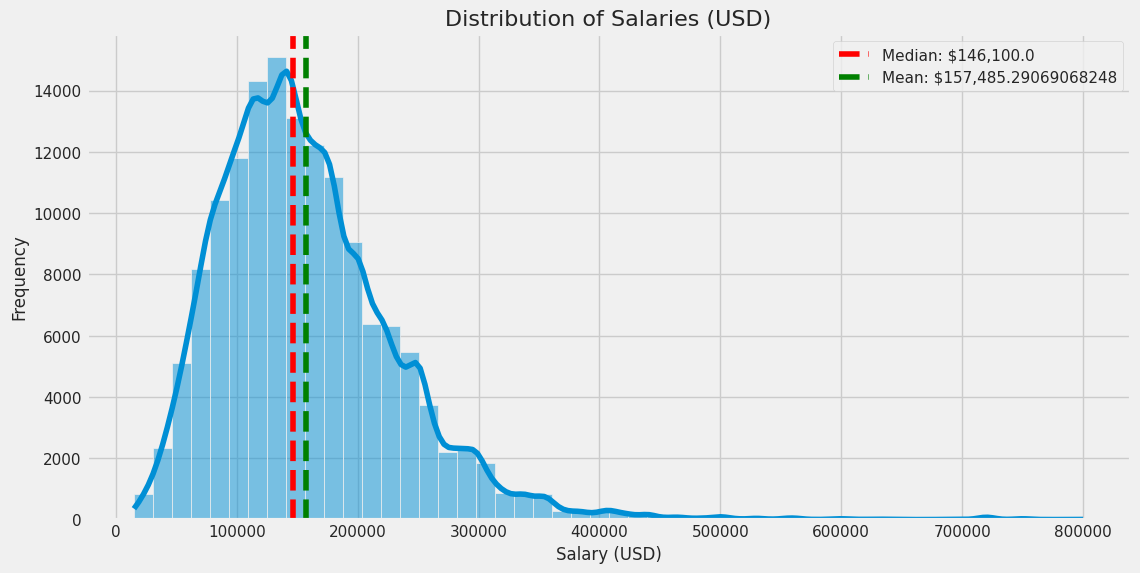

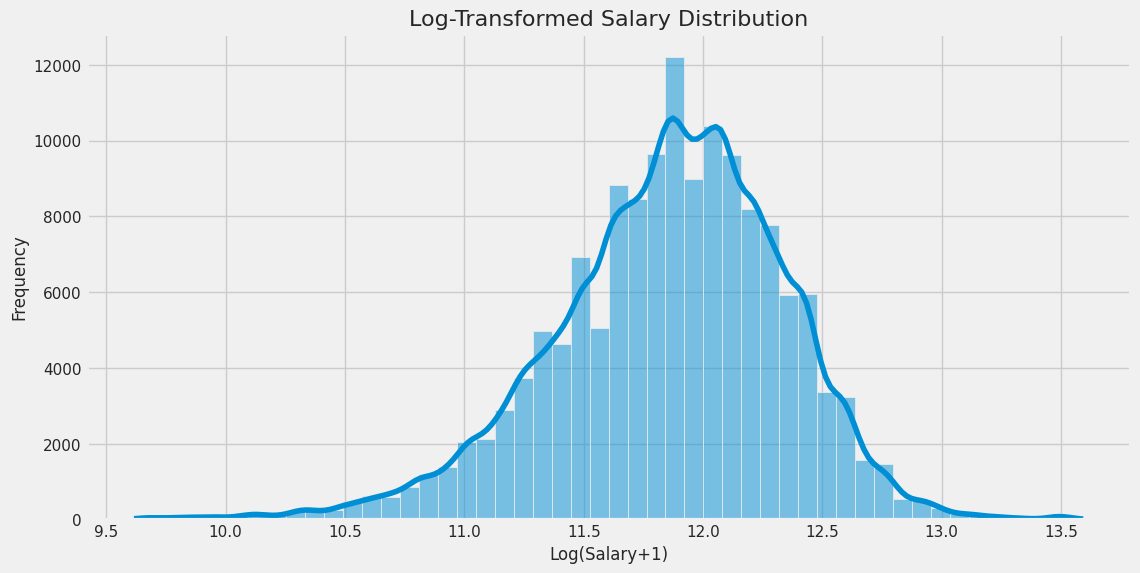

In [7]:
# Distribution of salaries in USD
plt.figure(figsize=(12, 6))
sns.histplot(df['salary_in_usd'], kde=True, bins=50)
plt.title('Distribution of Salaries (USD)', fontsize=16)
plt.xlabel('Salary (USD)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.axvline(df['salary_in_usd'].median(), color='red', linestyle='--', label=f'Median: ${df["salary_in_usd"].median():,}')
plt.axvline(df['salary_in_usd'].mean(), color='green', linestyle='--', label=f'Mean: ${df["salary_in_usd"].mean():,}')
plt.legend()
plt.show()

# Log-transformed salary distribution (to handle skewness)
plt.figure(figsize=(12, 6))
sns.histplot(np.log1p(df['salary_in_usd']), kde=True, bins=50)
plt.title('Log-Transformed Salary Distribution', fontsize=16)
plt.xlabel('Log(Salary+1)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.show()

The salary distribution is right-skewed, with a significant number of high-paying outliers. This is typical for salary data. The log transformation gives us a more normal distribution, which will be useful for modeling.

2. Trend Over Time

In [8]:
# Yearly salary trends
yearly_stats = df.groupby('work_year')['salary_in_usd'].agg(['mean', 'median', 'std']).reset_index()

fig = px.line(yearly_stats, x='work_year', y=['mean', 'median'],
              title='Data Science Salary Trends (2020-2025)',
              labels={'value': 'Salary (USD)', 'work_year': 'Year', 'variable': 'Metric'},
              template='plotly_white')

fig.update_layout(legend_title_text='', hovermode='x unified',
                 width=900, height=500)

# Add range for standard deviation
fig.add_trace(go.Scatter(
    x=np.concatenate([yearly_stats['work_year'], yearly_stats['work_year'][::-1]]),
    y=np.concatenate([yearly_stats['mean'] + yearly_stats['std'],
                     (yearly_stats['mean'] - yearly_stats['std'])[::-1]]),
    fill='toself',
    fillcolor='rgba(0,100,80,0.2)',
    line=dict(color='rgba(255,255,255,0)'),
    name='Standard Deviation'
))

fig.show()

We can observe a steady increase in both mean and median salaries from 2020 to 2025, with the gap between them widening slightly, indicating increasing inequality in the field.

3. Experience Level Distribution

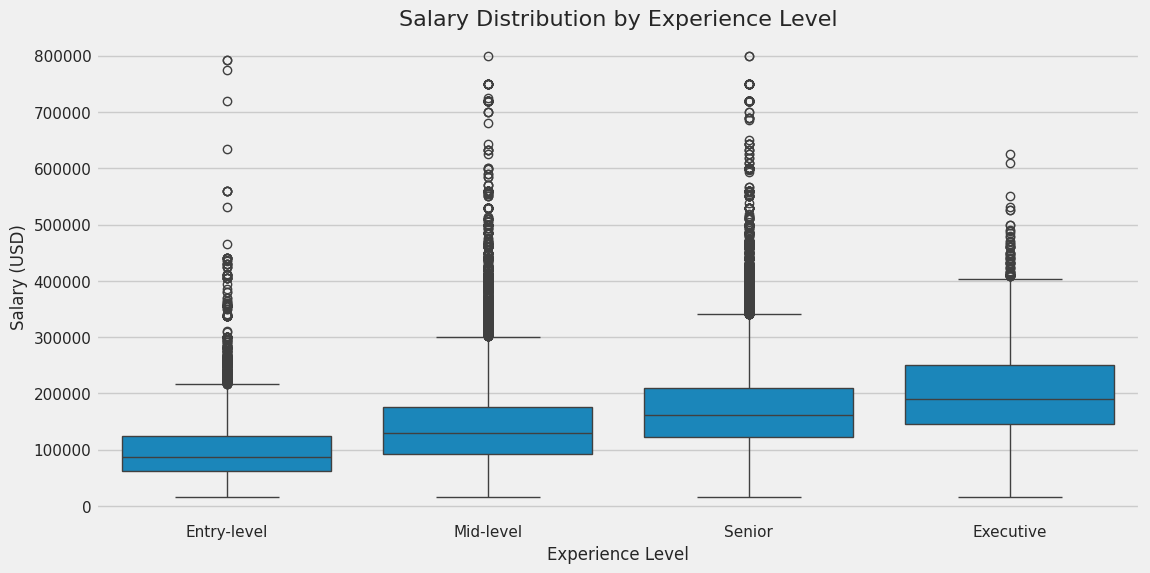

In [9]:
# Experience level salary comparison
plt.figure(figsize=(12, 6))
sns.boxplot(x='experience_level', y='salary_in_usd', data=df, order=['EN', 'MI', 'SE', 'EX'])
plt.title('Salary Distribution by Experience Level', fontsize=16)
plt.xlabel('Experience Level', fontsize=12)
plt.ylabel('Salary (USD)', fontsize=12)
plt.xticks(ticks=[0, 1, 2, 3], labels=['Entry-level', 'Mid-level', 'Senior', 'Executive'])
plt.show()

# Mean salary by experience level over time
exp_time = df.groupby(['work_year', 'experience_level'])['salary_in_usd'].mean().reset_index()
exp_time['experience_level'] = exp_time['experience_level'].replace({
    'EN': 'Entry-level', 'MI': 'Mid-level', 'SE': 'Senior', 'EX': 'Executive'
})

fig = px.line(exp_time, x='work_year', y='salary_in_usd', color='experience_level',
             title='Salary Trends by Experience Level (2020-2025)',
             labels={'salary_in_usd': 'Average Salary (USD)', 'work_year': 'Year'},
             template='plotly_white')

fig.update_layout(width=900, height=500, hovermode='x unified')
fig.show()

As expected, experience level has a significant impact on salary, with executives earning substantially more than other levels. The growth rate for executive salaries appears to be steeper, indicating increasing premiums for leadership roles.


4. Job Title Analysis

In [43]:
# Top 15 job titles by count
top_jobs = df['job_title'].value_counts().head(15)
print("Distribution of top common job titles:")
print(top_jobs)


Distribution of top common job titles:
job_title
Data Scientist               18311
Software Engineer            16416
Data Engineer                15965
Data Analyst                 13423
Engineer                     10566
Machine Learning Engineer     8705
Manager                       7473
Analyst                       5088
Research Scientist            3372
Product Manager               2472
Applied Scientist             2339
Associate                     2291
Data Architect                2158
Analytics Engineer            2073
AI Engineer                   1911
Name: count, dtype: int64


In [44]:
# Mean salary for top job titles
top_jobs_salary = df[df['job_title'].isin(top_jobs.index)].groupby('job_title')['salary_in_usd'].mean().sort_values(ascending=False)

fig = px.bar(x=top_jobs_salary.index, y=top_jobs_salary.values,
            labels={'x': 'Job Title', 'y': 'Average Salary (USD)'},
            title='Average Salary by Top Common Job Titles',
            color=top_jobs_salary.values, color_continuous_scale='Viridis')

fig.update_layout(xaxis_tickangle=-45, width=1000, height=600)
fig.show()

In [48]:
job_salary_time = df.groupby(['work_year', 'job_title'])['salary_in_usd'].mean().reset_index()
job_salary_time = job_salary_time[job_salary_time['job_title'].isin(top_jobs.index[:15])]

custom_colors = [
    "#1f77b4",  # blue
    "#ff7f0e",  # orange
    "#2ca02c",  # green
    "#d62728",  # red
    "#9467bd",  # purple
    "#8c564b",  # brown
    "#e377c2",  # pink
    "#7f7f7f",  # gray
    "#bcbd22",  # yellow-green
    "#17becf",  # cyan
    "#aec7e8",  # light blue
    "#ffbb78",  # light orange
    "#98df8a",  # light green
    "#ff9896",  # light red
    "#c5b0d5",  # light purple
]


# Mean salary by top job titles over time
fig = px.line(job_salary_time, x='work_year', y='salary_in_usd', color='job_title',
             title='Salary Trends by Top Common Job Titles (2020-2025)',
             labels={'salary_in_usd': 'Average Salary (USD)', 'work_year': 'Year'},
             template='plotly_white', color_discrete_sequence=custom_colors)

fig.update_layout(width=900, height=900, hovermode='x unified')
fig.show()



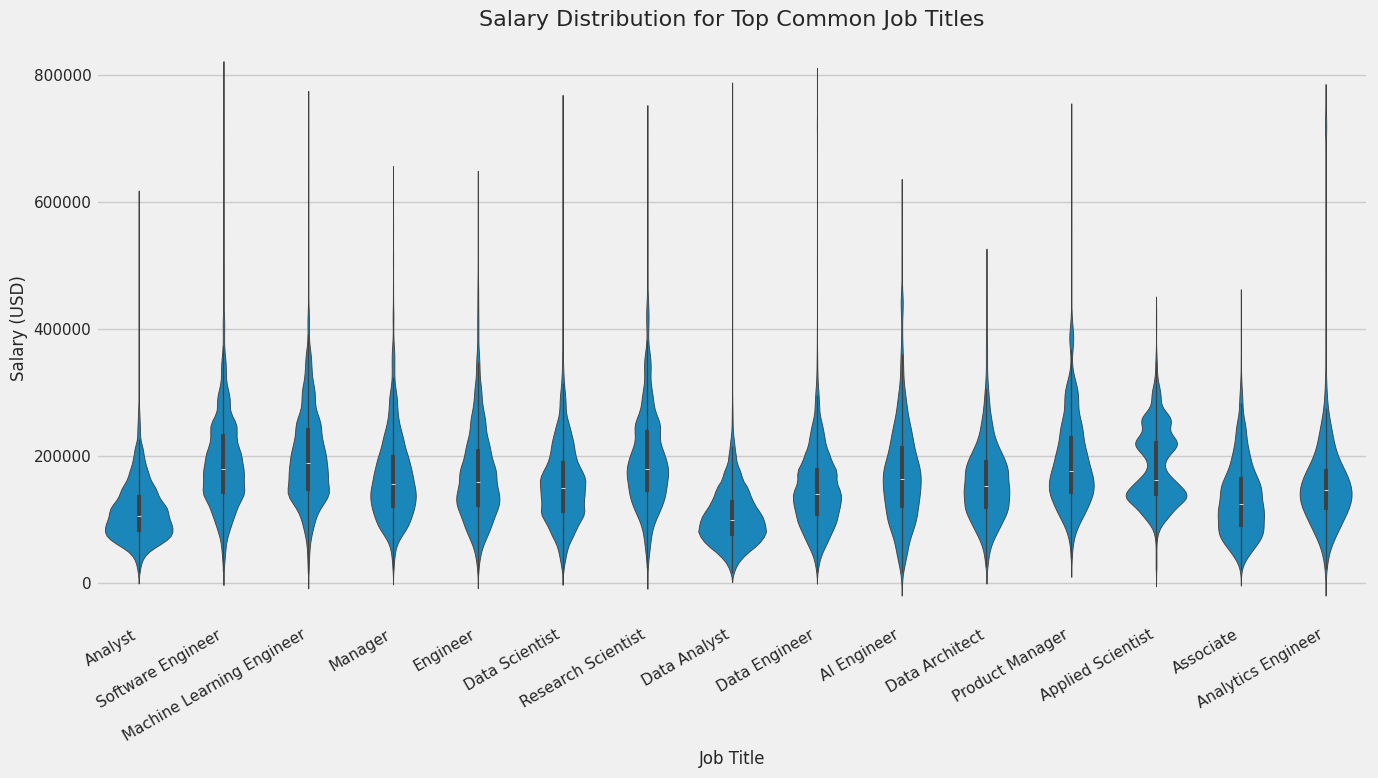

In [46]:
# Salary distribution for top common job titles
plt.figure(figsize=(14, 8))
sns.violinplot(x='job_title', y='salary_in_usd', data=df[df['job_title'].isin(top_jobs.index)])
plt.title('Salary Distribution for Top Common Job Titles', fontsize=16)
plt.xlabel('Job Title', fontsize=12)
plt.ylabel('Salary (USD)', fontsize=12)
plt.xticks(rotation=30, ha='right')
plt.tight_layout()
plt.show()

Among the most common job titles, Machine Learning Engineers and Research Scientists tend to command the highest salaries, while Data Analysts typically earn less. Software Engineers show the widest salary distribution, reflecting the diverse range of roles under this title.


5. Geographical Analysis

In [11]:
# Create mapping from ISO-2 to country names for visualization
iso2_to_name = {
    "AD": "Andorra","AE": "United Arab Emirates","AF": "Afghanistan","AG": "Antigua and Barbuda","AI": "Anguilla","AL": "Albania","AM": "Armenia","AO": "Angola","AQ": "Antarctica","AR": "Argentina","AS": "American Samoa","AT": "Austria","AU": "Australia","AW": "Aruba","AX": "ÅÅland Islands","AZ": "Azerbaijan","BA": "Bosnia and Herzegovina","BB": "Barbados","BD": "Bangladesh","BE": "Belgium","BF": "Burkina Faso","BG": "Bulgaria","BH": "Bahrain","BI": "Burundi","BJ": "Benin","BL": "Saint Barthélemy","BM": "Bermuda","BN": "Brunei Darussalam","BO": "Bolivia, Plurinational State of","BQ": "Bonaire, Sint Eustatius and Saba","BR": "Brazil","BS": "Bahamas","BT": "Bhutan","BV": "Bouvet Island","BW": "Botswana","BY": "Belarus","BZ": "Belize","CA": "Canada","CC": "Cocos (Keeling) Islands","CD": "Congo, Democratic Republic of the","CF": "Central African Republic", "CG": "Congo","CH": "Switzerland","CI": "Côte d'Ivoire","CK": "Cook Islands","CL": "Chile","CM": "Cameroon","CN": "China","CO": "Colombia","CR": "Costa Rica","CU": "Cuba","CV": "Cabo Verde","CW": "Curaçao","CX": "Christmas Island","CY": "Cyprus","CZ": "Czechia","DE": "Germany","DJ": "Djibouti","DK": "Denmark","DM": "Dominica","DO": "Dominican Republic","DZ": "Algeria","EC": "Ecuador","EE": "Estonia","EG": "Egypt","EH": "Western Sahara","ER": "Eritrea","ES": "Spain","ET": "Ethiopia","FI": "Finland","FJ": "Fiji","FK": "Falkland Islands (Malvinas)","FM": "Micronesia, Federated States of","FO": "Faroe Islands","FR": "France","GA": "Gabon","GB": "United Kingdom of Great Britain and Northern Ireland","GD": "Grenada","GE": "Georgia","GF": "French Guiana","GG": "Guernsey","GH": "Ghana","GI": "Gibraltar","GL": "Greenland","GM": "Gambia","GN": "Guinea","GP": "Guadeloupe","GQ": "Equatorial Guinea","GR": "Greece","GS": "South Georgia and the South Sandwich Islands","GT": "Guatemala","GU": "Guam","GW": "Guinea-Bissau","GY": "Guyana","HK": "Hong Kong","HM": "Heard Island and McDonald Islands","HN": "Honduras","HR": "Croatia","HT": "Haiti","HU": "Hungary","ID": "Indonesia","IE": "Ireland","IL": "Israel","IM": "Isle of Man","IN": "India","IO": "British Indian Ocean Territory","IQ": "Iraq","IR": "Iran, Islamic Republic of","IS": "Iceland","IT": "Italy","JE": "Jersey","JM": "Jamaica","JO": "Jordan","JP": "Japan","KE": "Kenya","KG": "Kyrgyzstan","KH": "Cambodia","KI": "Kiribati","KM": "Comoros","KN": "Saint Kitts and Nevis","KP": "Korea, Democratic People's Republic of","KR": "Korea, Republic of","KW": "Kuwait","KY": "Cayman Islands","KZ": "Kazakhstan","LA": "Lao People's Democratic Republic","LB": "Lebanon","LC": "Saint Lucia","LI": "Liechtenstein","LK": "Sri Lanka","LR": "Liberia","LS": "Lesotho","LT": "Lithuania","LU": "Luxembourg","LV": "Latvia","LY": "Libya","MA": "Morocco","MC": "Monaco","MD": "Moldova, Republic of","ME": "Montenegro","MF": "Saint Martin (French part)","MG": "Madagascar","MH": "Marshall Islands","MK": "North Macedonia","ML": "Mali","MM": "Myanmar","MN": "Mongolia","MO": "Macao","MP": "Northern Mariana Islands","MQ": "Martinique","MR": "Mauritania","MS": "Montserrat","MT": "Malta","MU": "Mauritius","MV": "Maldives","MW": "Malawi","MX": "Mexico","MY": "Malaysia","MZ": "Mozambique","NA": "Namibia","NC": "New Caledonia","NE": "Niger","NF": "Norfolk Island","NG": "Nigeria","NI": "Nicaragua","NL": "Netherlands, Kingdom of the","NO": "Norway","NP": "Nepal","NR": "Nauru","NU": "Niue","NZ": "New Zealand","OM": "Oman","PA": "Panama","PE": "Peru","PF": "French Polynesia","PG": "Papua New Guinea","PH": "Philippines","PK": "Pakistan","PL": "Poland","PM": "Saint Pierre and Miquelon","PN": "Pitcairn","PR": "Puerto Rico","PS": "Palestine, State of","PT": "Portugal","PW": "Palau","PY": "Paraguay","QA": "Qatar","RE": "Réunion","RO": "Romania","RU": "Russian Federation","RW": "Rwanda","SA": "Saudi Arabia","SB": "Solomon Islands","SC": "Seychelles","SD": "Sudan","SE": "Sweden","SG": "Singapore","SH": "Saint Helena, Ascension and Tristan da Cunha","SI": "Slovenia","SJ": "Svalbard and Jan Mayen","SK": "Slovakia","SL": "Sierra Leone","SM": "San Marino","SN": "Senegal","SO": "Somalia","SR": "Suriname","SS": "South Sudan","ST": "Sao Tome and Principe","SV": "El Salvador","SX": "Sint Maarten (Dutch part)","SY": "Syrian Arab Republic","SZ": "Eswatini","TC": "Turks and Caicos Islands","TD": "Chad","TF": "French Southern Territories","TG": "Togo","TH": "Thailand","TJ": "Tajikistan","TK": "Tokelau","TL": "Timor-Leste","TM": "Turkmenistan","TN": "Tunisia","TO": "Tonga","TR": "Türkiye","TT": "Trinidad and Tobago","TV": "Tuvalu","TW": "Taiwan, Province of China","TZ": "Tanzania, United Republic of","UA": "Ukraine","UG": "Uganda","UM": "United States Minor Outlying Islands","US": "United States of America","UY": "Uruguay","UZ": "Uzbekistan","VA": "Holy See","VC": "Saint Vincent and the Grenadines","VE": "Venezuela, Bolivarian Republic of","VG": "Virgin Islands (British)","VI": "Virgin Islands (U.S.)","VN": "Viet Nam","VU": "Vanuatu","WF": "Wallis and Futuna","WS": "Samoa","YE": "Yemen","YT": "Mayotte","ZA": "South Africa","ZM": "Zambia","ZW": "Zimbabwe"
}

In [12]:
# Base adjusted_salary column
df['adjusted_salary'] = df['salary_in_usd']  # Kept the same by default

# Count number of employees per country
people_count = df.groupby('employee_residence').size().reset_index(name='num_people')

# Calculate average salary by employee residence
avg_salary_by_residence = df.groupby('employee_residence')['adjusted_salary'].mean().reset_index()

# Merge data for display
avg_salary_by_residence = avg_salary_by_residence.merge(people_count, on='employee_residence')

# Add country names for mapping
avg_salary_by_residence['country_name'] = avg_salary_by_residence['employee_residence'].map(iso2_to_name)
avg_salary_by_residence = avg_salary_by_residence.dropna(subset=['country_name'])  # Drop unmapped countries

# Create the choropleth map
fig2 = px.choropleth(avg_salary_by_residence,
                     locations='country_name',
                     locationmode='country names',
                     color='adjusted_salary',
                     hover_name='country_name',
                     hover_data={
                         'employee_residence': True,
                         'adjusted_salary': ':.0f',
                         'num_people': True
                     },
                     color_continuous_scale=px.colors.sequential.Plasma,
                     title='Average Salary by Employee Residence',
                     labels={'adjusted_salary': 'Average Adjusted Salary'},
                     projection='natural earth')

fig2.update_layout(width=1000, height=600)
fig2.show()



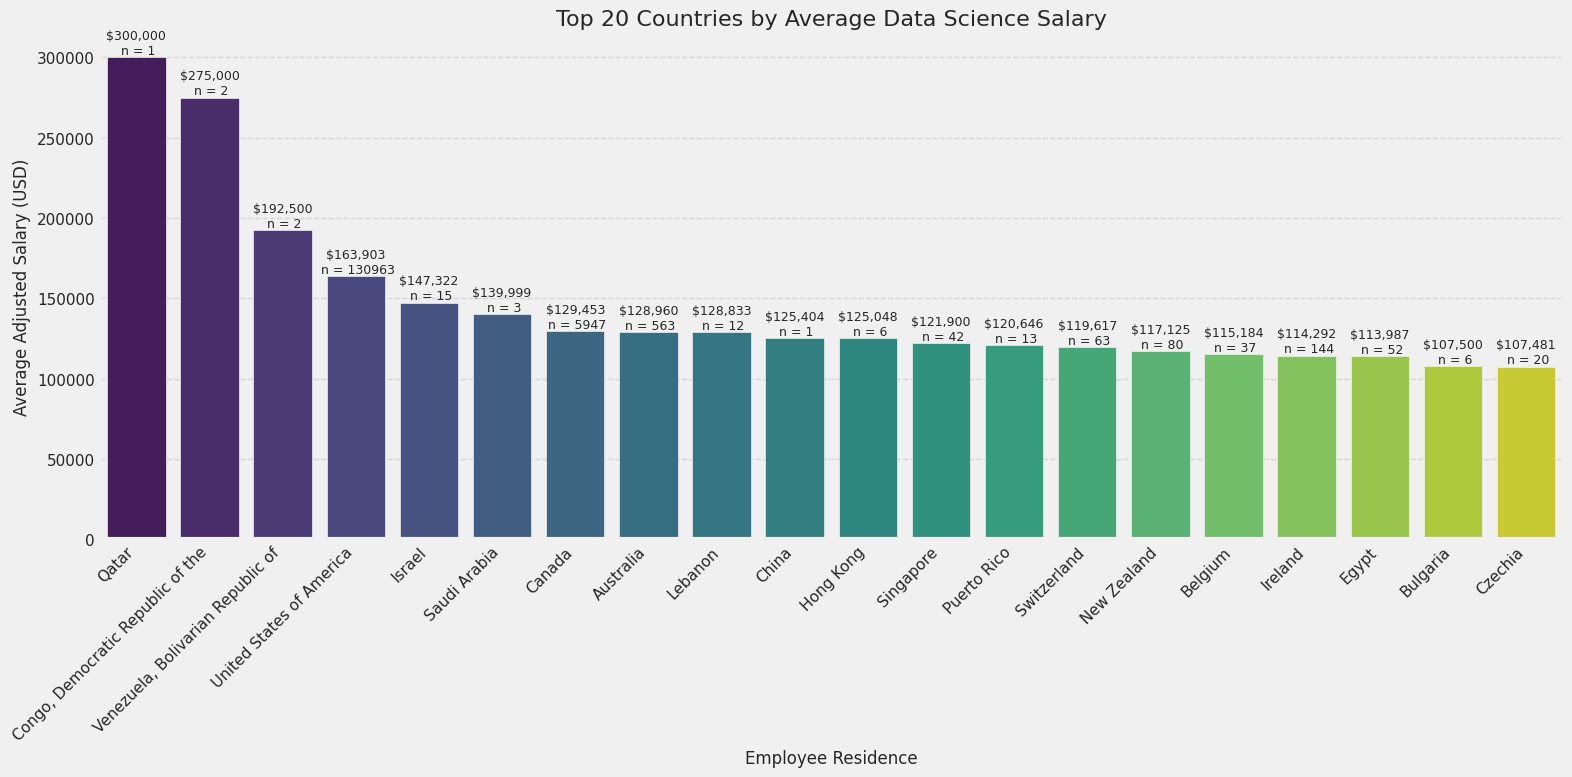

In [13]:
# Create a sorted bar chart for top 20 countries
top_countries = avg_salary_by_residence.sort_values('adjusted_salary', ascending=False).head(20)

plt.figure(figsize=(16, 8))
chart = sns.barplot(x='country_name', y='adjusted_salary', data=top_countries,
                    palette='viridis', order=top_countries['country_name'])
plt.title('Top 20 Countries by Average Data Science Salary', fontsize=16)
plt.xlabel('Employee Residence', fontsize=12)
plt.ylabel('Average Adjusted Salary (USD)', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add salary values on top of bars
for i, bar in enumerate(chart.patches):
    chart.text(bar.get_x() + bar.get_width()/2.,
              bar.get_height() + 2000,
              f'${top_countries["adjusted_salary"].iloc[i]:,.0f}\n n = {top_countries["num_people"].iloc[i]}',
              ha='center', fontsize=9)

plt.tight_layout()
plt.show()

The highest average salaries include Qatar, Congo, and Venezuela above the US. However, the number of data entries from those countries are very low, making them unreliable in representing the mean salary of the country.

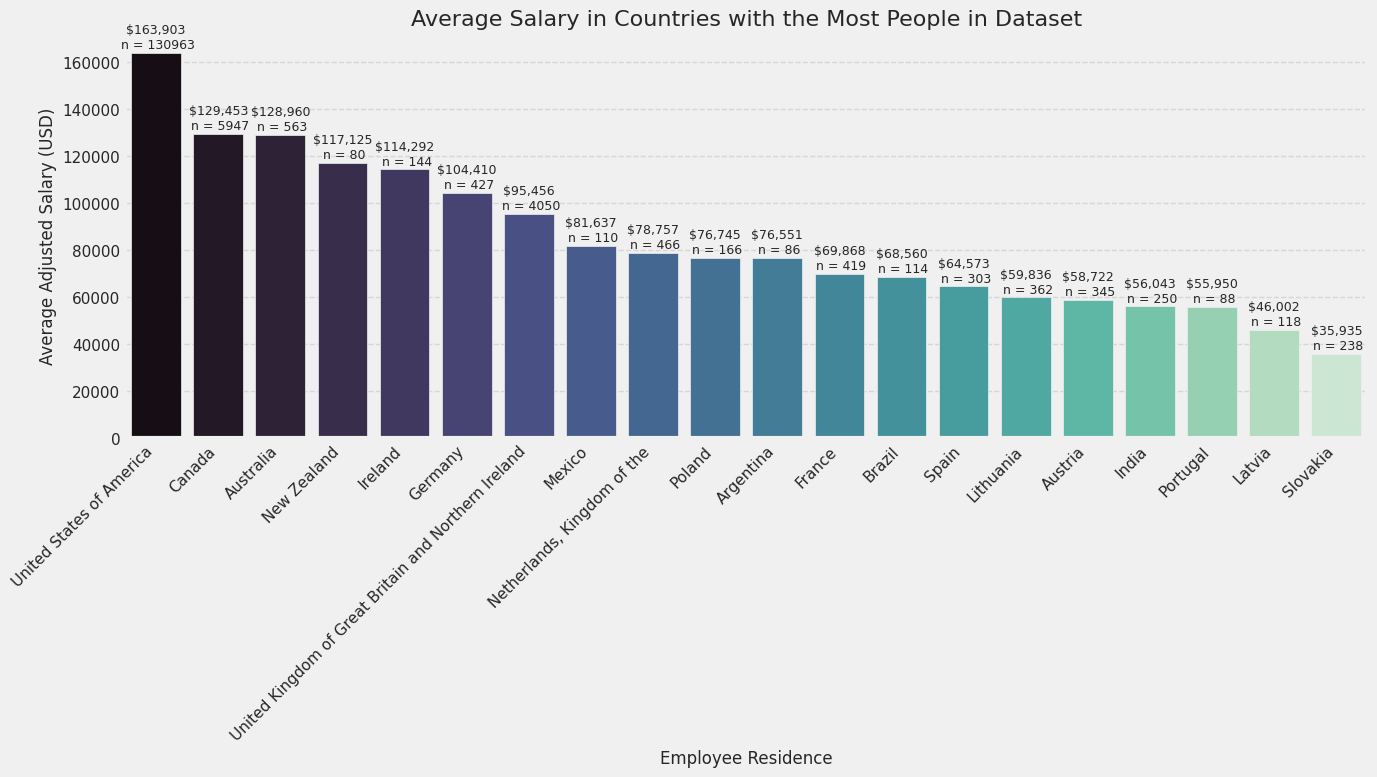

In [14]:
# Get top 20 countries by number of people
top20_by_count = avg_salary_by_residence.sort_values('num_people', ascending=False).head(20)

# Sort again for better display
top20_by_count = top20_by_count.sort_values('adjusted_salary', ascending=False)

# Plot the bar chart (showing average salary)
plt.figure(figsize=(14, 8))
chart3 = sns.barplot(x='country_name', y='adjusted_salary', data=top20_by_count,
                     palette='mako', order=top20_by_count['country_name'])
plt.title('Average Salary in Countries with the Most People in Dataset', fontsize=16)
plt.xlabel('Employee Residence', fontsize=12)
plt.ylabel('Average Adjusted Salary (USD)', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Annotate with salary and number of people
for i, bar in enumerate(chart3.patches):
    chart3.text(bar.get_x() + bar.get_width()/2.,
                bar.get_height() + 2000,
                f'${top20_by_count["adjusted_salary"].iloc[i]:,.0f}\n n = {top20_by_count["num_people"].iloc[i]}',
                ha='center', fontsize=9)

plt.tight_layout()
plt.show()


The US, Canada, and Australia lead in data science salaries for countries with a lot of data.


6. Remote Work Analysis

In [15]:
# Salary by remote ratio
remote_salary = df.groupby('remote_ratio')['salary_in_usd'].agg(['mean', 'median', 'count']).reset_index()
remote_salary['remote_ratio'] = remote_salary['remote_ratio'].map({0: 'On-site', 50: 'Hybrid', 100: 'Remote'})

fig = px.bar(remote_salary, x='remote_ratio', y=['mean', 'median'],
            barmode='group', title='Salary by Remote Work Ratio',
            labels={'value': 'Salary (USD)', 'remote_ratio': 'Work Setting', 'variable': 'Metric'},
            color_discrete_sequence=['#2a9d8f', '#e76f51'])

fig.update_layout(width=800, height=500)
fig.show()

# Remote ratio trends over time
remote_time = df.groupby(['work_year', 'remote_ratio']).size().reset_index(name='count')
total_per_year = remote_time.groupby('work_year')['count'].sum().reset_index()
remote_time = remote_time.merge(total_per_year, on='work_year', suffixes=('', '_total'))
remote_time['percentage'] = (remote_time['count'] / remote_time['count_total']) * 100
remote_time['remote_ratio'] = remote_time['remote_ratio'].map({0: 'On-site', 50: 'Hybrid', 100: 'Remote'})

fig = px.line(remote_time, x='work_year', y='percentage', color='remote_ratio',
             title='Remote Work Trends (2020-2025)',
             labels={'percentage': 'Percentage of Jobs', 'work_year': 'Year'},
             template='plotly_white')

fig.update_layout(width=900, height=500, hovermode='x unified')
fig.show()

Fully remote positions tend to offer higher salaries on average. We can also observe a significant shift toward remote work after 2020 (likely due to the COVID-19 pandemic), with the trend stabilizing around 2023-2024 but still showing a higher remote work percentage compared to pre-2020 levels.


7. Company Size Impact

In [16]:
# Salary by company size
company_salary = df.groupby(['company_size', 'experience_level'])['salary_in_usd'].median().reset_index()
company_salary['company_size'] = company_salary['company_size'].map({'S': 'Small', 'M': 'Medium', 'L': 'Large'})
company_salary['experience_level'] = company_salary['experience_level'].map({
    'EN': 'Entry-level', 'MI': 'Mid-level', 'SE': 'Senior', 'EX': 'Executive'
})

fig = px.bar(company_salary, x='company_size', y='salary_in_usd', color='experience_level',
            barmode='group', title='Median Salary by Company Size and Experience Level',
            labels={'salary_in_usd': 'Median Salary (USD)', 'company_size': 'Company Size'},
            template='plotly_white')

fig.update_layout(width=900, height=500)
fig.show()

Larger companies generally offer higher salaries across all experience levels, with the gap most pronounced at the executive level. This reflects the greater resources and revenue of larger organizations.


8. Currency Analysis

In [17]:
# Top salary currencies
currency_counts = df['salary_currency'].value_counts().head(10)

fig = px.pie(values=currency_counts.values, names=currency_counts.index,
            title='Distribution of Salary Currencies',
            template='plotly_white')

fig.update_traces(textposition='inside', textinfo='percent+label')
fig.update_layout(width=700, height=500)
fig.show()

# Exchange rate analysis (implied from salary and salary_in_usd)
df['implied_exchange_rate'] = df['salary'] / df['salary_in_usd']
top_currencies = df['salary_currency'].value_counts().head(10).index.tolist()
exchange_rates = df[df['salary_currency'].isin(top_currencies)].groupby(['work_year', 'salary_currency'])['implied_exchange_rate'].median().reset_index()

fig = px.line(exchange_rates, x='work_year', y='implied_exchange_rate', color='salary_currency',
             title='Implied Exchange Rate Trends (2020-2025)',
             labels={'implied_exchange_rate': 'Rate vs USD', 'work_year': 'Year'},
             template='plotly_white')

fig.update_layout(width=900, height=500, hovermode='x unified')
fig.show()



USD dominates as the primary currency for data science salaries globally. The exchange rate analysis shows relative currency strength over time, with some currencies showing depreciation against the USD.


9. Correlation Analysis

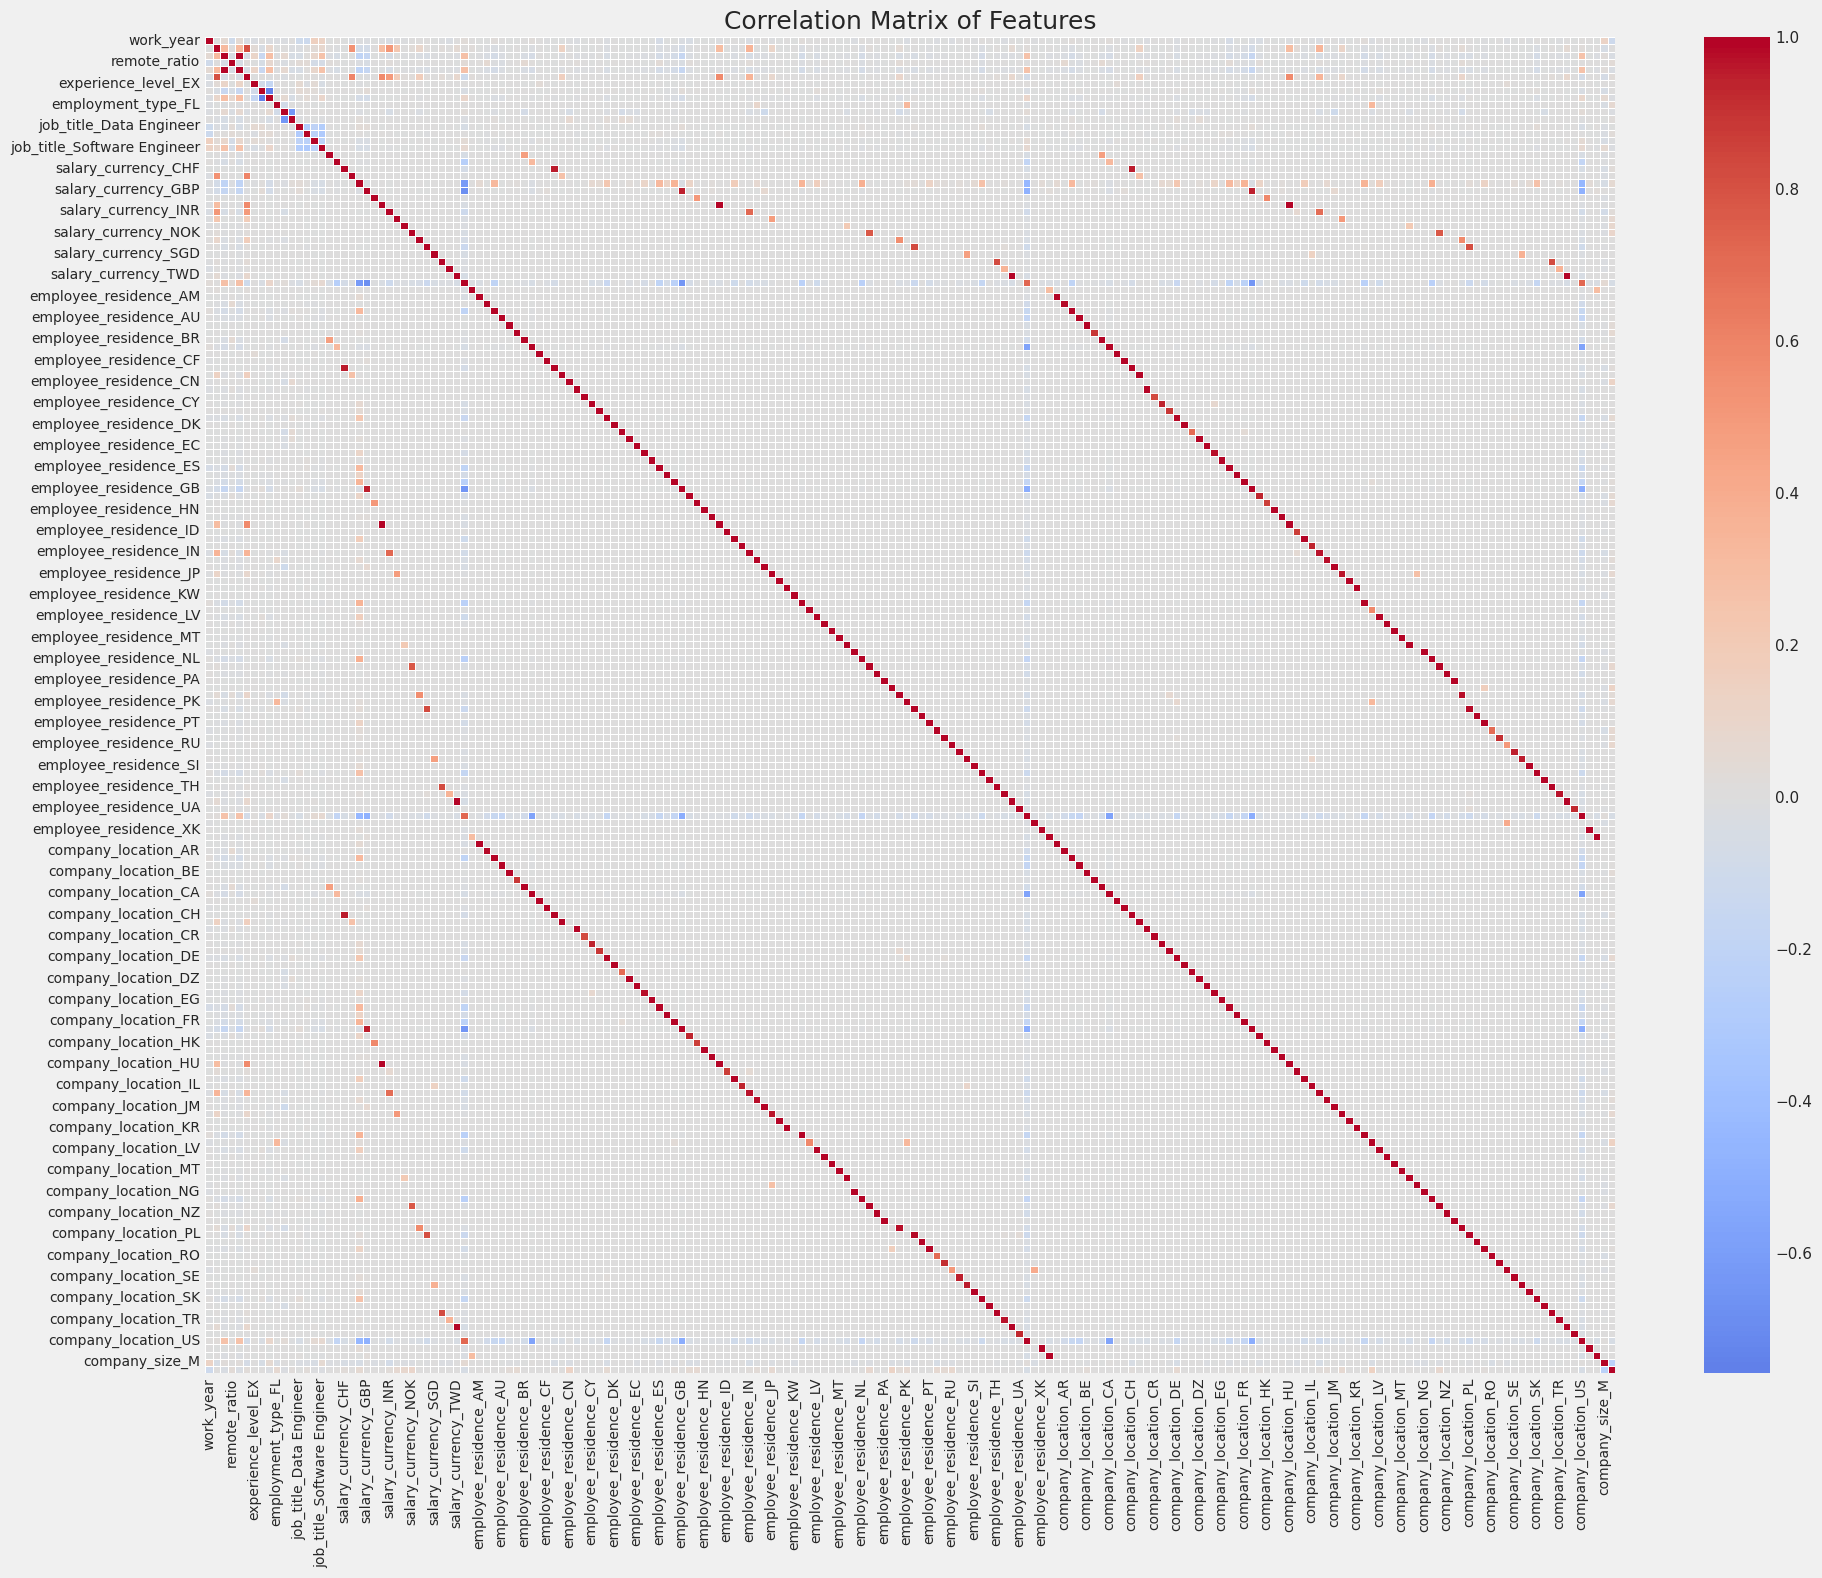

Top 10 features positively correlated with salary:
salary_in_usd                  1.000000
adjusted_salary                1.000000
salary                         0.315223
experience_level_SE            0.282815
salary_currency_USD            0.274724
job_title_Software Engineer    0.263875
employee_residence_US          0.262454
company_location_US            0.261681
experience_level_EX            0.101641
job_title_Engineer             0.090416
employment_type_FT             0.067879
Name: salary_in_usd, dtype: float64

Top 10 features negatively correlated with salary:
company_location_ES     -0.068533
company_location_FR     -0.073212
employee_residence_FR   -0.073801
company_location_LT     -0.074939
employee_residence_LT   -0.074939
experience_level_MI     -0.142080
employee_residence_GB   -0.156103
company_location_GB     -0.156450
salary_currency_GBP     -0.164948
salary_currency_EUR     -0.196940
Name: salary_in_usd, dtype: float64


In [18]:
# Create dummy variables for categorical features
categorical_cols = ['experience_level', 'employment_type', 'job_title', 'salary_currency',
                    'employee_residence', 'company_location', 'company_size']
numerical_cols = ['work_year', 'salary', 'salary_in_usd', 'remote_ratio']

# Select top job titles for simplified correlation analysis
top_job_titles = df['job_title'].value_counts().head(5).index.tolist()
df_corr = df[df['job_title'].isin(top_job_titles)].copy()

# Create dummy variables
df_dummies = pd.get_dummies(df_corr, columns=categorical_cols, drop_first=True)

# Calculate and plot correlation matrix
corr_matrix = df_dummies.corr()
plt.figure(figsize=(20, 16))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', center=0, linewidths=0.5)
plt.title('Correlation Matrix of Features', fontsize=18)
plt.xticks(fontsize=10, rotation=90)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()

# Key salary correlations
salary_corr = corr_matrix['salary_in_usd'].sort_values(ascending=False)
print("Top 10 features positively correlated with salary:")
print(salary_corr.head(11))  # Including salary_in_usd itself
print("\nTop 10 features negatively correlated with salary:")
print(salary_corr.tail(10))

The correlation analysis reveals strong relationships between salary and factors like experience level, company size, and certain job titles. We can use these insights for feature selection in our models.

Our comprehensive analysis of the data science salary dataset has yielded several valuable insights:

* Salary Determinants: Experience level, company location, and job category are the strongest predictors of salary in the data science field. Executive positions command significantly higher salaries than other levels.

* Geographic Impact: The US, Canada, and Australia consistently offer the highest salaries. There's a substantial gap between top-paying countries and emerging tech markets.

* Remote Work Is Fine: Fully remote positions tend to offer the same salaries on average as in-site locations, despite having a lower number of instances, showing the flexibility of job positions where such arrangements is possible.

* Career Growth: The transition from Senior to Executive level shows the largest percentage increase in salary, highlighting the significant premium placed on leadership skills.

* Job Title Differentiation: Machine Learning Engineers and Research Scientists command higher salaries than Data Analysts and general Software Engineers, reflecting the specialized skills required.

* Company Size Effect: Larger companies generally offer higher compensation across all experience levels, with the gap most pronounced at the executive level.



This analysis and the resulting model can be used for:

* Career Planning: Understanding the financial impact of different career paths and transitions
* Negotiation Support: Data-backed reference points for salary negotiations
* Location Strategy: Evaluating remote work opportunities across different geographies
* Recruitment Planning: Setting competitive compensation packages for data science roles



To further enhance this analysis, we could:

* Incorporate education level and specific skills data
* Add cost of living adjustments to provide normalized comparisons
* Include industry vertical information to differentiate between sectors
* Develop a time-series model to forecast future salary trends


Source:
*   https://www.kaggle.com/code/adilshamim8/eda-on-data-science-salaries

